# Recent Surveys

This notebook evaluates the most recent surveys and is a benchmark to see how good we can predict consumption using the public available data.

In [4]:
cd ..

/Users/emmaboehly/Documents/Master1/Machine Learning/Projet2/predicting-poverty-through-time/src


In [5]:
%autoreload 2
%load_ext autoreload
%matplotlib inline

UsageError: Line magic function `%autoreload` not found.


In [6]:
from lib import estimator_util as eu
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [7]:
sns.set_theme()

In [8]:
complete_df, all_cols = eu.get_data("../data/lsms/processed/_all_real.csv", "../data/cnn_features/resnet_trans_all_countries_hyper.csv", "../data/")

## Predict r^2 for every country in our dataset.

In [9]:
def cnn_osm(complete, model_, params = None):
    countries = ["NG", "ETH" ,"TZA", "MW"]
    all_trained_models = []
    for i, country in enumerate(countries):
        tmp_df = complete.loc[complete.country == country]
        years = tmp_df.groupby(["year"]).groups.keys()
        year = max(years)
        X, y = eu.get_recent_features(tmp_df, [country], all_cols)
        r2, y_real, y_predicted, trained_model = eu.run_model(X, y, model_, seed=1, **(params[i]))
        fig = eu.plot_predictions(y_real, y_predicted, r2, country, year, i)
        fig.savefig(f"../figs/{country}_{year}_cnnosm_{model_}.pdf", dpi=600)
        all_trained_models.append(trained_model)
    return all_trained_models

### Prediction using Ridge Regression

[Ridge(alpha=1000), Ridge(alpha=1000), Ridge(alpha=1000), Ridge(alpha=1000)]

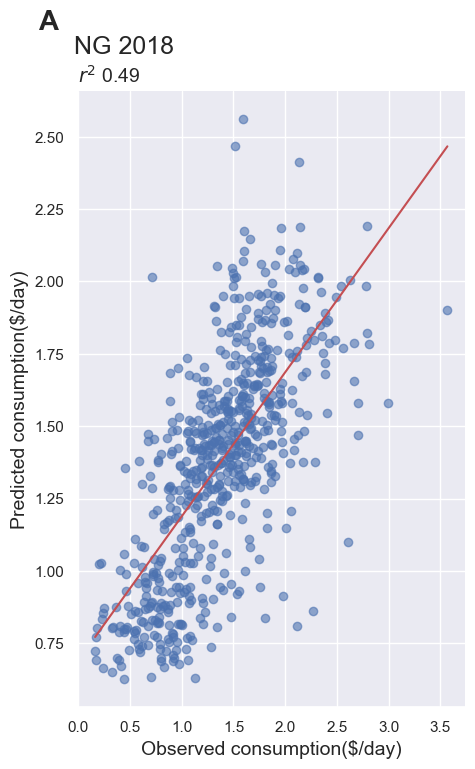

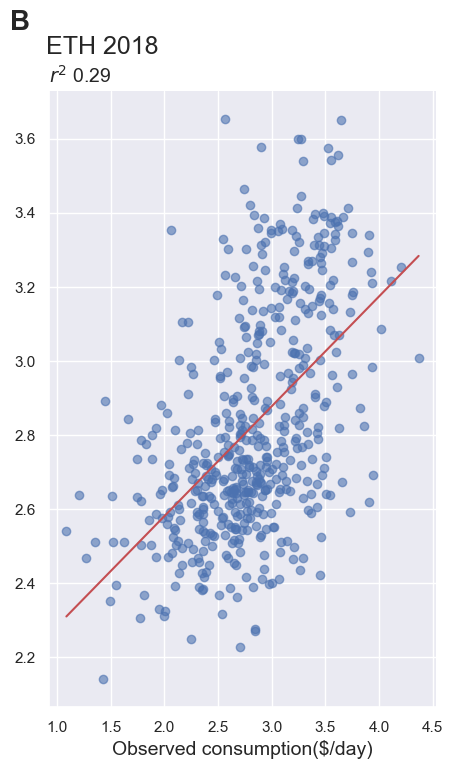

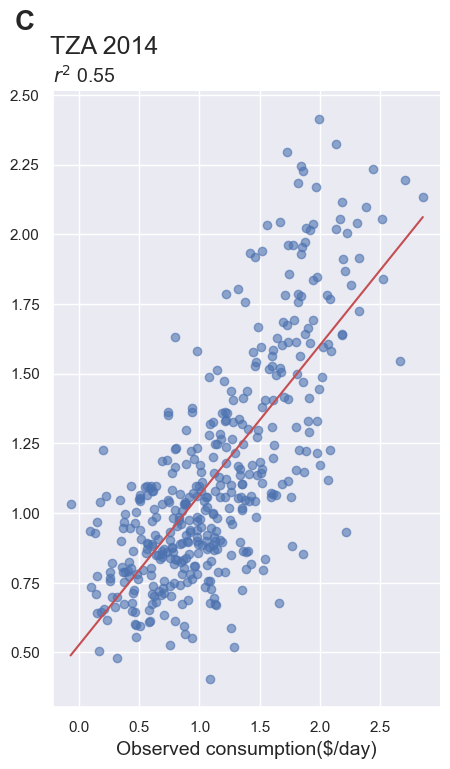

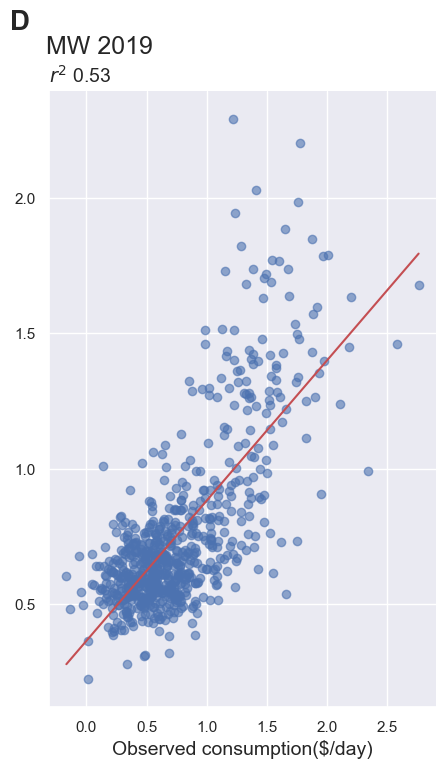

In [15]:
cnn_osm(complete_df, Ridge, [{'alpha' : 1000}]*4)

### Prediction using XGBoost

In [16]:
#Parameters optimization
import multiprocessing
import plotly.express as px
def optimise_xgboost(complete, max_depth = [2,4], n_estimators = [50,100]) : 
    countries = ["NG", "ETH" ,"TZA", "MW"]
    best_scores = []
    best_params = []
    for i, country in enumerate(countries):
        tmp_df = complete.loc[complete.country == country]
        years = tmp_df.groupby(["year"]).groups.keys()
        year = max(years)
        X, y = eu.get_recent_features(tmp_df, [country], all_cols)
        xgb_model = XGBRegressor(n_jobs=multiprocessing.cpu_count() // 2)
        xgb = GridSearchCV(xgb_model, {'max_depth': max_depth, 'n_estimators': n_estimators}, 
                           verbose=1, n_jobs=2, return_train_score=True)
        xgb.fit(X, y)
        best_scores.append(xgb.best_score_)
        best_params.append(xgb.best_params_)
        #gridsearch_results = pd.DataFrame(xgb.cv_results_)
        #max_depth_plot = gridsearch_results.param_max_depth
        #n_estimators_plot = gridsearch_results.param_n_estimators
        #scores_plot = gridsearch_results.mean_test_score
        
        #fig = px.scatter_3d(xgb.cv_results_, x='param_max_depth', y='param_n_estimators', z='mean_test_score')
        #fig.show()
    return best_scores, best_params

In [17]:
best_scores, best_params = optimise_xgboost(complete_df)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


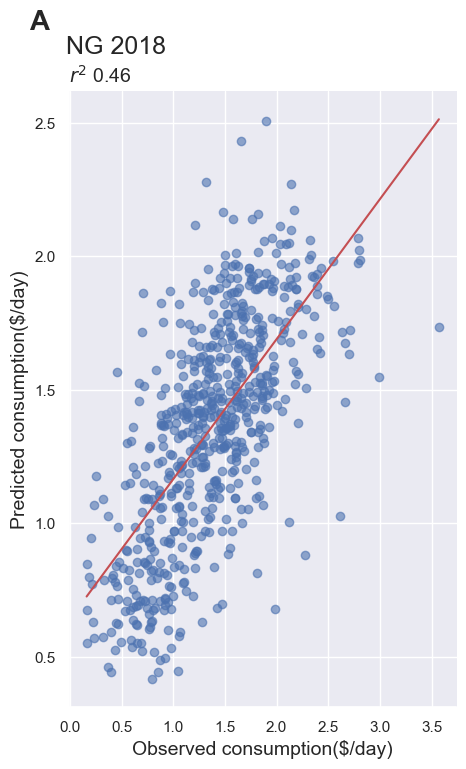

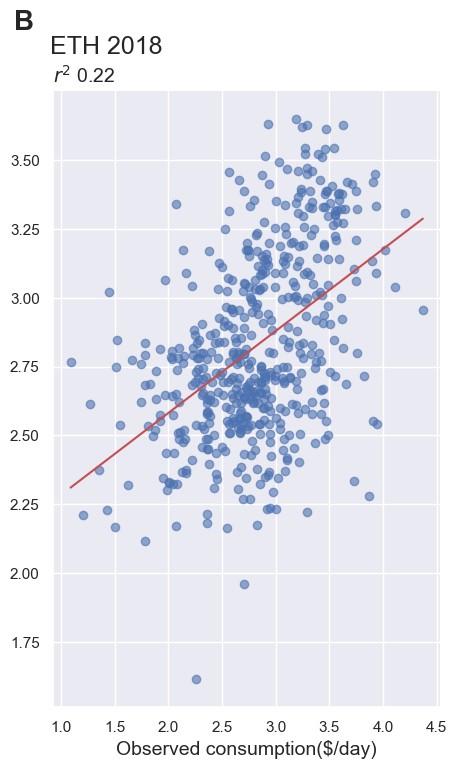

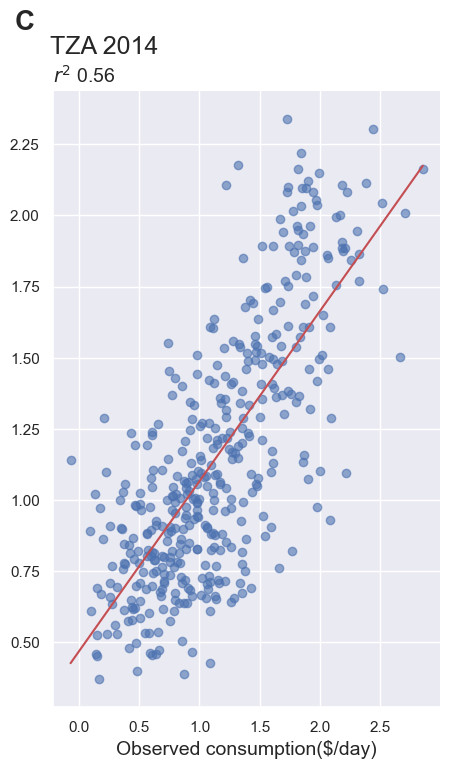

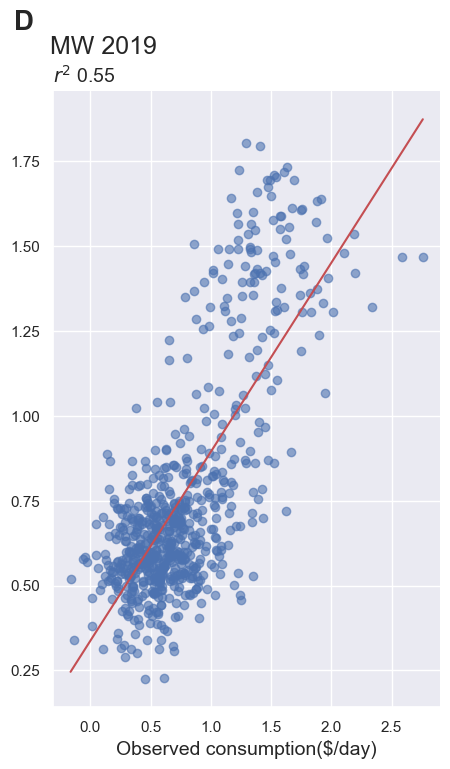

In [18]:
models = cnn_osm(complete_df, XGBRegressor, best_params)

## Predicting using Catboost

In [19]:
models = cnn_osm(complete_df, CatBoostRegressor)

TypeError: 'NoneType' object is not subscriptable

# Features importance

## With XGBoost

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (661,) and arg 3 with shape (158,).

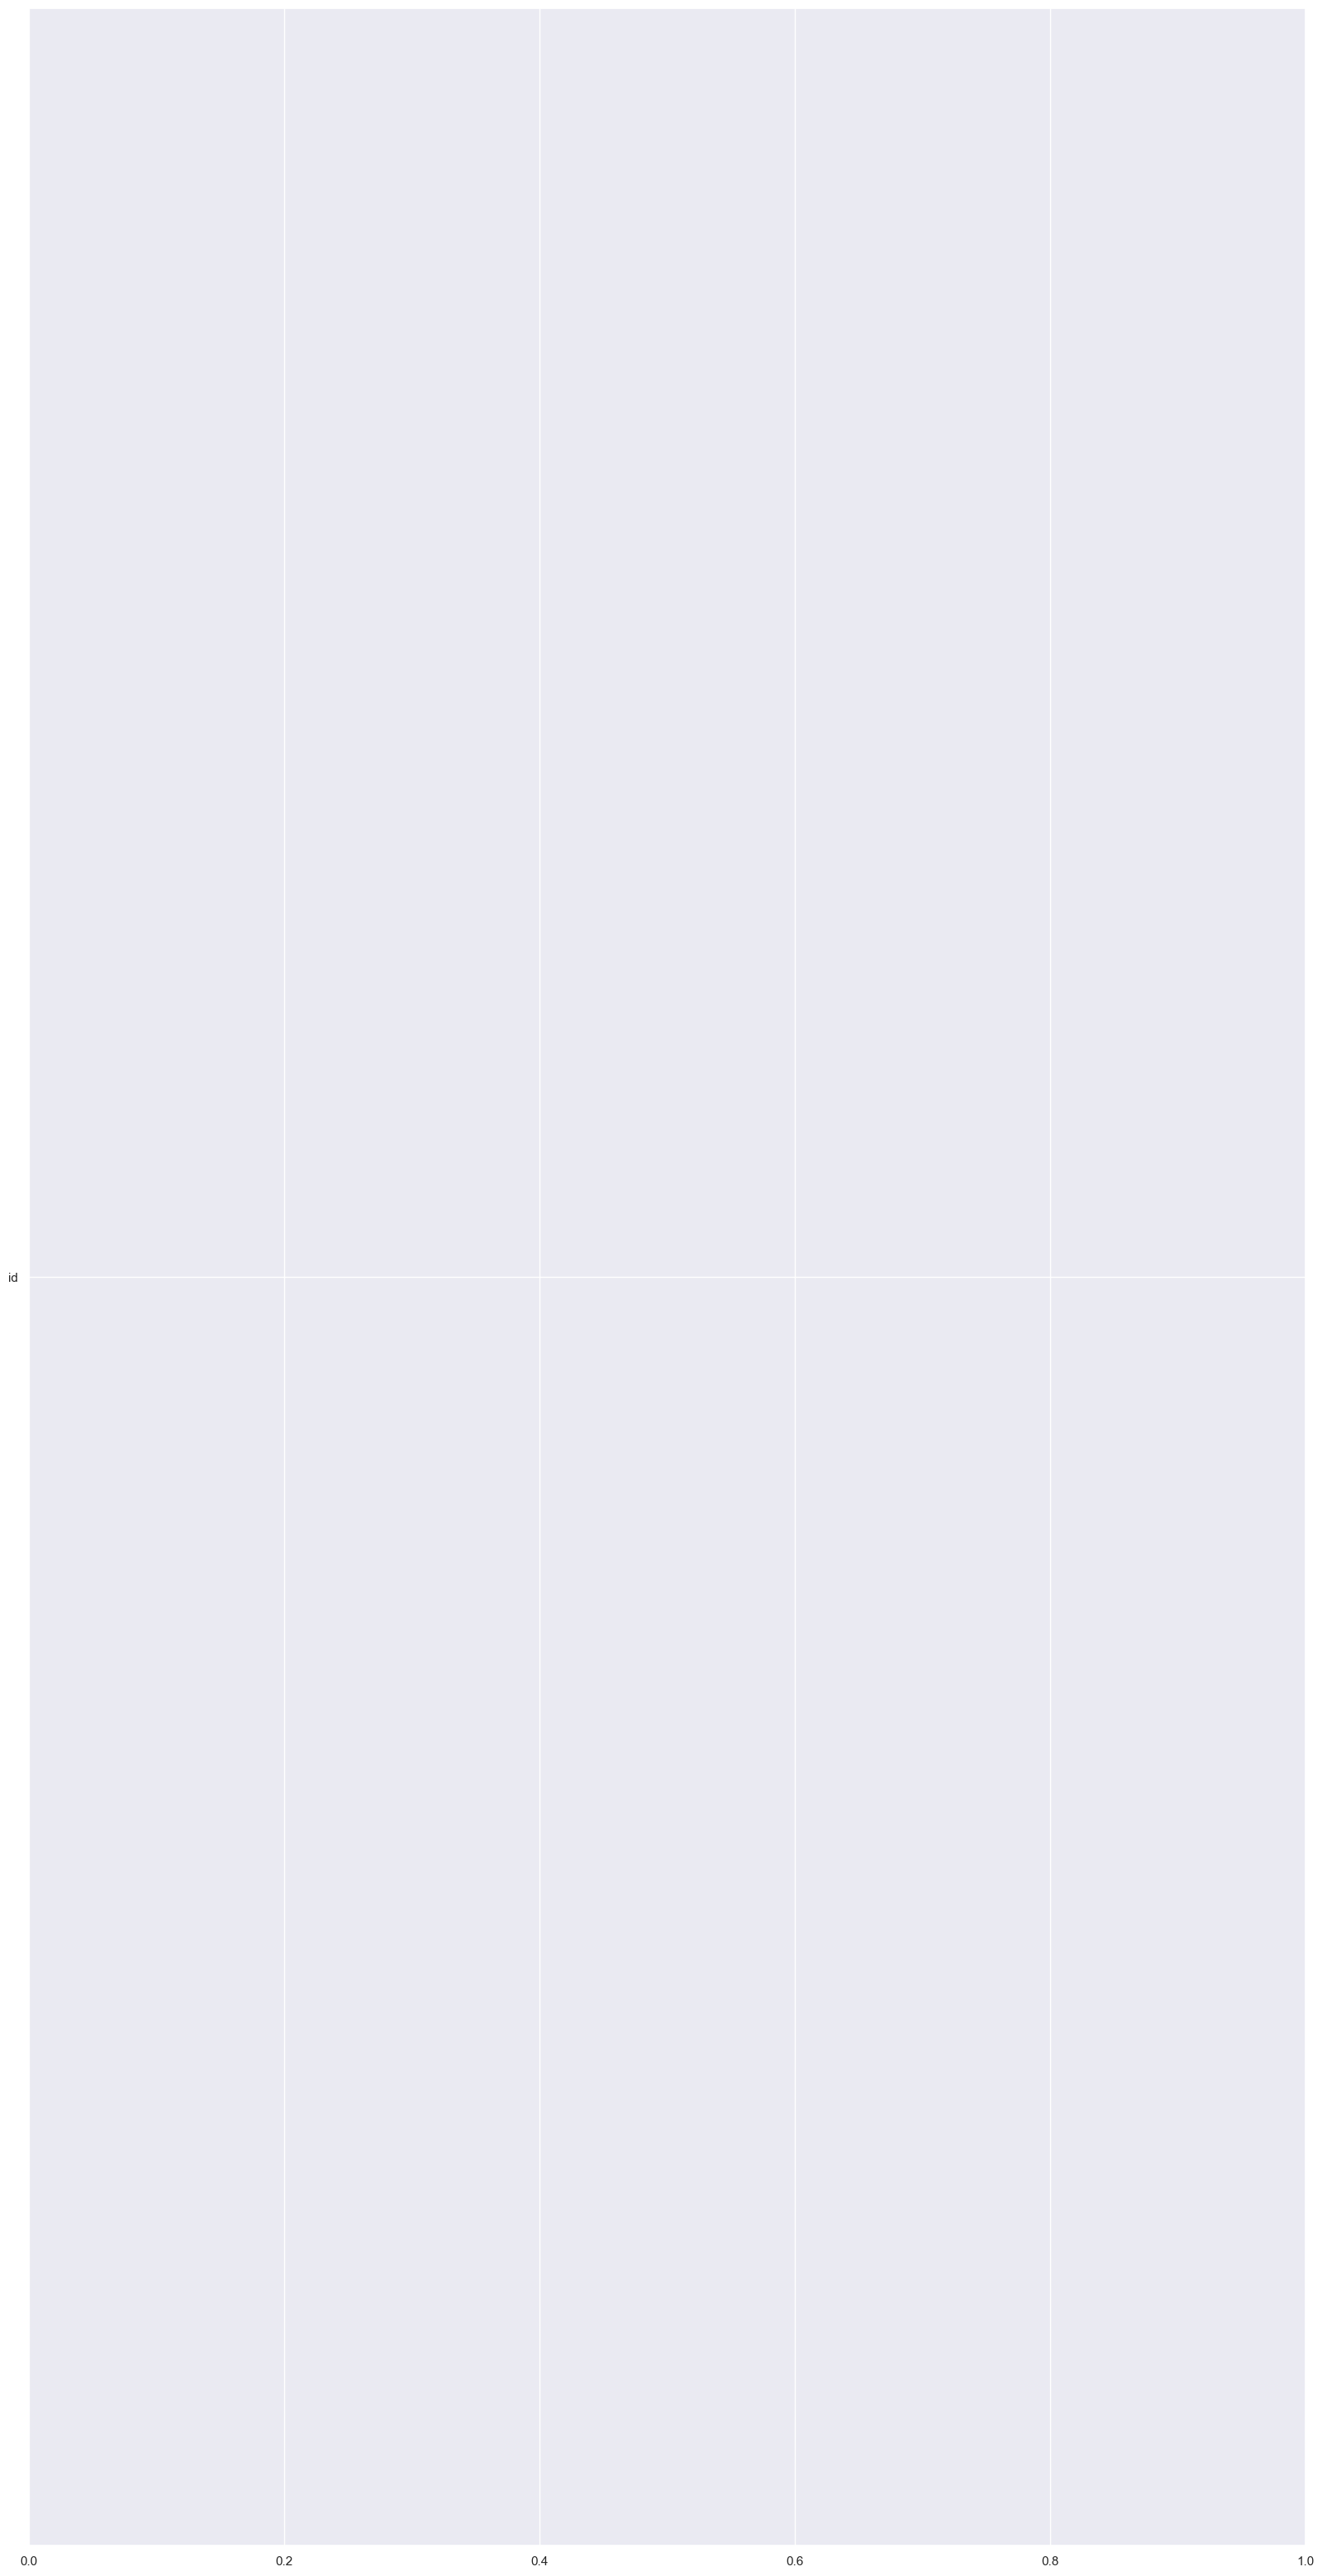

In [35]:
countries = ["NG", "ETH" ,"TZA", "MW"]
for i, country in enumerate(countries) : 
    importance = models[i].feature_importances_
    fig, ax = plt.subplots(figsize=(20, 40))
    features_names = all_cols 
    ax.barh(complete_df.columns, importance)
    plt.show()
    #plot_importance(models[i], importance_type='gain', title='Features importance', xlabel='Importance', ylabel='Features', grid=False, ax=ax)
    #print(models[i].feature_importances_)
    #plt.barh(models[i].feature_importances_, )

## Rural vs. Urban

In [ ]:
def rural_urban(complete):    
    types = ["rural", "urban"]
    types_r2 = {}
    rural = []
    ys = []
    y_preds = []
    # get features
    for type in types:    
        r2s = []
        countries = ["NG", "ETH" ,"TZA", "MW"]
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            year_df = year_df.loc[year_df.rural == type]
            rural += year_df.rural.values.tolist()
            cnn_X = np.array([np.array(x) for x in year_df["features"].values])
            osm_X = year_df[all_cols].values
            tmp_X = np.hstack((cnn_X, osm_X))
            y_ = year_df["cons_pc"].values

            if X is None:
                X = tmp_X
            else:
                X = np.vstack((X, tmp_X))
            
            if y is None:
                y = y_
            else:
                y = np.append(y, y_)

        y = np.log(y)
        ys += y.tolist()
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
        r, y_hest, _ = eu.run_model(X, y, Ridge, alpha=1000)
        y_preds += y_hest.tolist()
        r2s.append(r)
        types_r2[type] = r2s

    # for the plot
    plt_df = pd.DataFrame.from_dict({"y": ys, "y_pred": y_preds, "rural": rural})

    x_col = "y"
    y_col = "y_pred"
    hue_col = "rural"

    penguins = plt_df
    g = sns.jointplot(data=penguins, x=x_col, y=y_col, hue=hue_col)
    
    for _, gr in penguins.groupby(hue_col):
        sns.regplot(x=x_col, y=y_col, data=gr, scatter=False, ax=g.ax_joint, truncate=False)
    print(types_r2)
    g.ax_joint.set_xlabel("Observed nominal consumption($/day)")
    g.ax_joint.set_ylabel("Predicted nominal consumption($/day)")
    plt.text(-0.8, 1, fr"$r^2 = {round(types_r2['rural'][0], 2)}$", c="#4c72b0")
    plt.text(-0.8, 0.8, fr"$r^2 = {round(types_r2['urban'][0], 2)}$", c="#dd8452")
    plt.legend([],[], frameon=False)
    g.ax_joint.get_legend().remove()
    g.ax_joint.text(-0.1, 1.1, string.ascii_uppercase[0], size=20, weight='bold', transform=g.ax_joint.transAxes)
    plt.savefig("../figs/rural_urban_pop.pdf", dpi=600, bbox_inches="tight")


In [ ]:
rural_urban(complete_df)

## Predict % of poorest people in dataset

### Prediction using Ridge

In [ ]:
pooled_features_perc(complete_df)

## Predicting performance from each feature alone and combined

In [ ]:
def prediction_features_performance(complete):   
    features = ["CNN", "OSM", "CNN+OSM"]
    feature_r2 = {}
    for feature in features:    
        r2s = []        
        countries = ["NG", "ETH" ,"TZA", "MW"]
        X = None
        y = None
        for i, country in enumerate(countries):
            tmp_df = complete.loc[complete.country == country]
            years = tmp_df.groupby(["year"]).groups.keys()
            year = max(years)
            year_df = tmp_df.loc[tmp_df.year == year]
            if feature == "CNN":
                tmp_X = np.array([np.array(x) for x in year_df["features"].values])
                tmp_X = StandardScaler().fit_transform(tmp_X)
            elif feature == "OSM":
                tmp_X = year_df[all_cols].values
            else:
                cnn_X = np.array([np.array(x) for x in year_df["features"].values])
                osm_X = year_df[all_cols].values
                tmp_X = np.hstack((cnn_X, osm_X))
                
            y = year_df["cons_pc"].values

            X = tmp_X
           
            y = np.log(y)
            scaler = StandardScaler().fit(X)
            X = scaler.transform(X)
            r, _, _ = eu.run_ridge(X, y, alpha=1000)
            r2s.append(r)
            feature_r2[feature] = r2s
            
    feat_df = pd.DataFrame.from_dict(feature_r2)
    feat_df["country"] = countries
    return feat_df

In [ ]:
prediction_features_performance(complete_df)